In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
import os
import sys
import glob
from copy import deepcopy
from astropy.io import fits
from scipy import stats

PROJECT_DIR = '/Users/research/projects/kepler-ecc-rp/'

sys.path.append(PROJECT_DIR)
from utils.stats import weighted_percentile
from utils.io import load_posteriors, extract_posteriors

pi = np.pi

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


## Load data

In [16]:
POPULATION = 'singles'

if POPULATION == 'singles':
    PATH = os.path.join(PROJECT_DIR, 'Results/20240829/alderaan-singles-LC-category5-histogram/')
if POPULATION == 'multis':
    PATH = os.path.join(PROJECT_DIR, 'Results/20240904/alderaan-multis-LC-category5-histogram/')
if POPULATION == 'injection':
    PATH = os.path.join(PROJECT_DIR, 'Results/20241004/injection-test-category5-histogram/')
    

files = list(np.sort(glob.glob(os.path.join(PATH, '*.fits'))))

samples, headers, bin_edges = load_posteriors(files)
rp, ecc, mult, nobj = extract_posteriors(samples, headers)

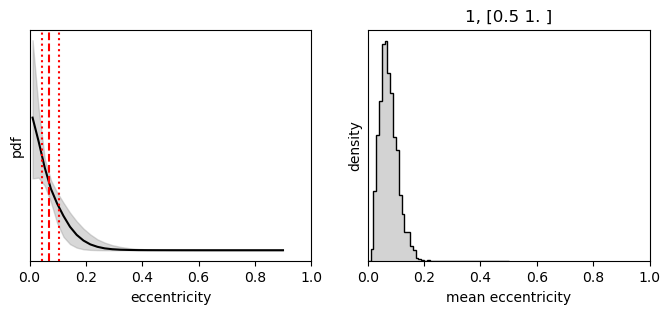

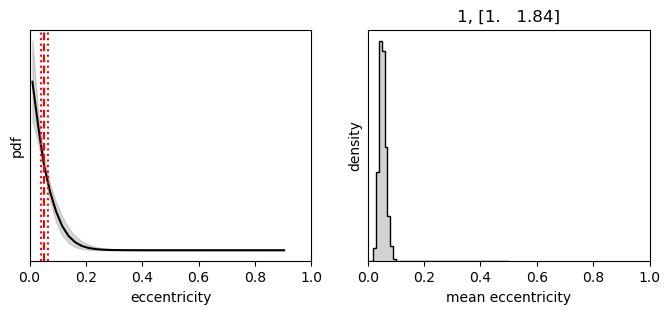

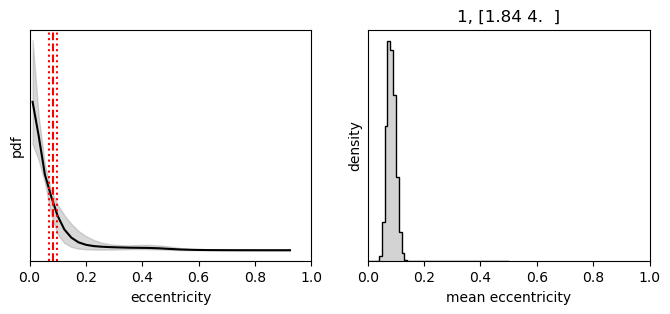

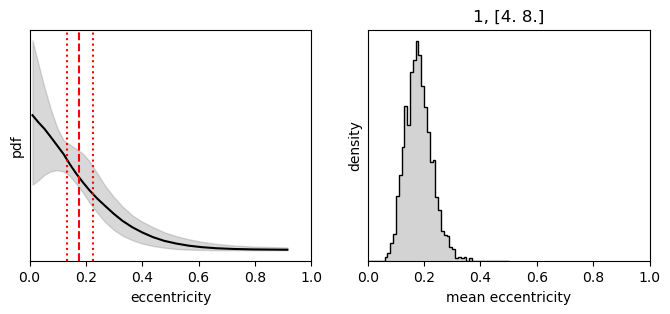

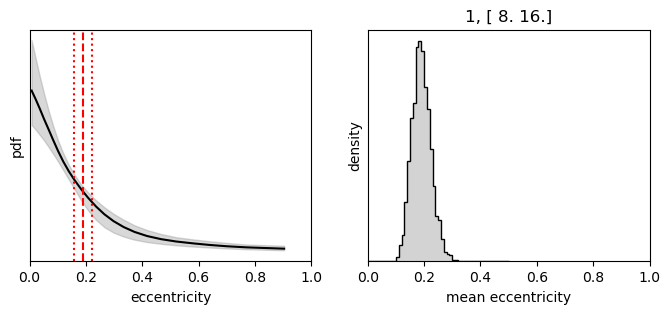

In [17]:
for i, s in enumerate(samples):
    bin_centers = 0.5*(bin_edges[i][1:] + bin_edges[i][:-1])
    
    ln_pdf = s.filter(regex='ln_pdf')
    ln_pdf = ln_pdf.reindex(sorted(ln_pdf.columns), axis=1)

    pdf = np.exp(np.percentile(ln_pdf, [16,50,84], axis=0))
    mu = np.percentile(ecc[i], [16,50,84])

    fig, ax = plt.subplots(1,2, figsize=(8,3))
    
    ax[0].plot(bin_centers, pdf[1], c='k')
    ax[0].fill_between(bin_centers, pdf[0], pdf[2], color='grey', alpha=0.3)
    ax[0].axvline(mu[0], color='r', ls=':')
    ax[0].axvline(mu[1], color='r', ls='--')
    ax[0].axvline(mu[2], color='r', ls=':')
    ax[0].set_xlim(0,1)
    ax[0].set_yticks([])
    ax[0].set_xlabel("eccentricity")
    ax[0].set_ylabel("pdf")
    
    ax[1].hist(ecc[i], color='lightgrey', bins=np.linspace(0,0.5,51))
    ax[1].hist(ecc[i], color='k', histtype='step', bins=np.linspace(0,0.5,51))
    ax[1].set_xlim(0,1)
    ax[1].set_yticks([])
    ax[1].set_xlabel("mean eccentricity")
    ax[1].set_ylabel("density")

    plt.title("{0}, {1}".format(mult[i], rp[i]))
    plt.show()

## Marginalization demo

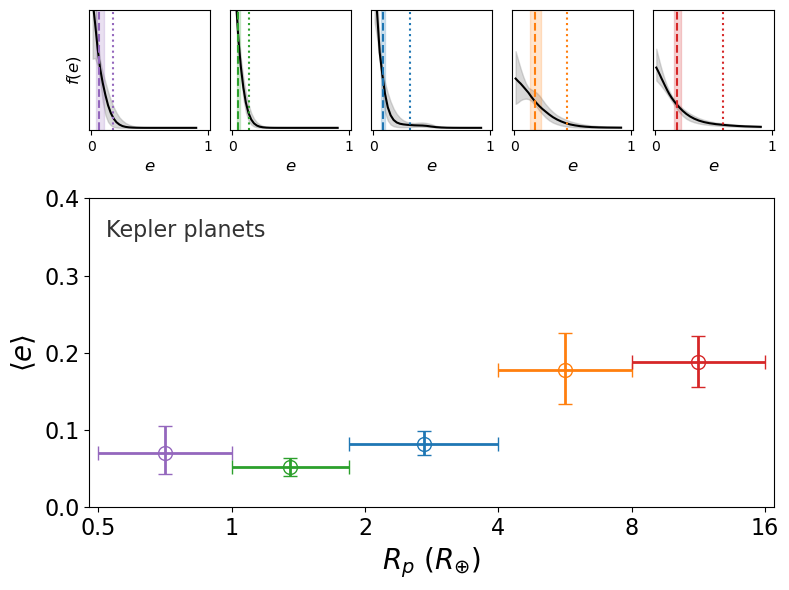

In [18]:
if POPULATION == 'singles':
    use = mult == 1
if POPULATION == 'multis':
    use = mult == 99
if POPULATION == 'injection':
    use = mult != 0
    
e_ = np.percentile(ecc[use], [16,50,84], axis=1).T
r_ = rp[use]

colors = ['C4', 'C2', 'C0', 'C1', 'C3']

plt.figure(figsize=(8,6))

# main axis
axM = plt.subplot2grid(shape=(3,5),loc=(1,0),rowspan=2, colspan=5)

yerr = np.abs(e_[:,(0,2)].T - e_[:,1])
xerr = np.abs(r_.T - np.exp(np.mean(np.log(r_), axis=1)))

for i in range(5):
    x = np.atleast_1d(np.exp(np.mean(np.log(r_[i]))))
    y = np.atleast_1d(e_[i,1])
    xe = np.atleast_2d(xerr[:,i]).T
    ye = np.atleast_2d(yerr[:,i]).T
    axM.errorbar(x, y, yerr=ye, xerr=xe, fmt='o', lw=2, ms=10, capsize=5, fillstyle='none', color=colors[i]) 

axM.set_xscale('log')
axM.set_xlim(0.5/1.05,16*1.05)
axM.set_xticks([0.5,1,2,4,8,16], [0.5,1,2,4,8,16], fontsize=16)
axM.set_ylim(0,0.4)
axM.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4], [0.0, 0.1, 0.2, 0.3, 0.4], fontsize=16)
axM.minorticks_off()
axM.set_xlabel("$R_p$ ($R_{\oplus}$)", fontsize=20)
axM.set_ylabel(r"$\langle e \rangle$", fontsize=20)


if POPULATION == 'injection':    
    axM.plot(np.linspace(0.5,4,100), 0.023*np.ones(100), 'k--', zorder=0)
    axM.plot(np.linspace(4,16,100), 0.23*np.ones(100), 'k--', zorder=0)
    axM.text(0.52, 0.35, "Recovery of injected eccentricities", fontsize=16, color='#333')
    
else:
    axM.text(0.52, 0.35, "Kepler planets", fontsize=16, color='#333')


# sub axes
for i, s in enumerate(samples):
    if use[i]:
        bin_widths = bin_edges[i][1:] - bin_edges[i][:-1]
        bin_centers = 0.5*(bin_edges[i][1:] + bin_edges[i][:-1])
        
        ln_pdf = s.filter(regex='ln_pdf')
        ln_pdf = ln_pdf.reindex(sorted(ln_pdf.columns), axis=1)
    
        pdf = np.exp(np.percentile(ln_pdf, [16,50,84], axis=0))
        w   = (pdf[1]*bin_widths)/np.sum(pdf[1]*bin_widths)
        e50 = np.percentile(ecc[i], [16,50,84])
        e95 = weighted_percentile(bin_centers, 95, w)       

        ax = plt.subplot2grid(shape=(3,5),loc=(0,i),rowspan=1, colspan=1)
        ax.plot(bin_centers, pdf[1], c='k')
        ax.fill_between(bin_centers, pdf[0], pdf[2], color='grey', alpha=0.3)

        ax.axvline(e50[1], color=colors[i], ls='--')
        ax.axvspan(e50[0], e50[2], color=colors[i], alpha=0.2)
        ax.axvline(e95, color=colors[i], ls=':')
        ax.set_xlim(-0.02,1.02)
        ax.set_xticks([0, 1])
        ax.set_xlabel("$e$", fontsize=12)
        ax.set_yticks([])
        ax.set_ylim(-0.2, 10)
        if i == 0:
            ax.set_ylabel("$f(e)$", fontsize=12)
            

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_DIR, 'Figures/marginalization-demo-{0}.pdf'.format(POPULATION)), bbox_inches='tight')
plt.show()

## Overlay distributions

In [ ]:
# load template distribution
x_template, y_template = np.loadtxt(os.path.join(PROJECT_DIR, 'template_distribution.txt')).T

In [ ]:
labels = ['sub-Earths', 'super-Earths', 'sub-Neptunes', 'sub-Saturns', 'Jovians']

fig, ax = plt.subplots()

for i, s in enumerate(samples):
    if use[i]:
        bin_widths = bin_edges[i][1:] - bin_edges[i][:-1]
        bin_centers = 0.5*(bin_edges[i][1:] + bin_edges[i][:-1])
        
        ln_pdf = s.filter(regex='ln_pdf')
        ln_pdf = ln_pdf.reindex(sorted(ln_pdf.columns), axis=1)
    
        pdf = np.exp(np.percentile(ln_pdf, [16,50,84], axis=0))

        ax.plot(bin_centers, pdf[1], color=colors[i], lw=2, ls='--', label=labels[i])
        
        
ax.plot(x_template, np.exp(y_template), color='k', lw=2, ls='-', label='all planets')       

ax.legend(loc='upper right', fontsize=12)
ax.set_xlim(0,1)
ax.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0], [0.0,0.2,0.4,0.6,0.8,1.0], fontsize=16)
ax.set_yticks([])
ax.set_xlabel('$e$', fontsize=24)
ax.set_ylabel('$f(e)$', fontsize=24)

plt.savefig(os.path.join(PROJECT_DIR, 'Figures', 'template-dist-{0}.pdf'.format(POPULATION)), bbox_inches='tight')
plt.show()

### Single-bin example

In [ ]:
i = 3
s = samples[i]

bin_widths = bin_edges[i][1:] - bin_edges[i][:-1]
bin_centers = 0.5*(bin_edges[i][1:] + bin_edges[i][:-1])

ln_pdf = s.filter(regex='ln_pdf')
ln_pdf = ln_pdf.reindex(sorted(ln_pdf.columns), axis=1)

pdf_draws = np.exp(ln_pdf.values)
e50_draws = []
for j, pdf in enumerate(pdf_draws):
    w = (pdf*bin_widths)/np.sum(pdf*bin_widths)
    e50_draws.append(weighted_percentile(bin_centers, 50, w))
    
    
pdf = np.percentile(pdf_draws, [16,50,84], axis=0)
w   = (pdf[1]*bin_widths)/np.sum(pdf[1]*bin_widths)
e50 = weighted_percentile(bin_centers, 50, w)
e95 = weighted_percentile(bin_centers, 95, w)


fig, ax = plt.subplots(figsize=(5,5))

ax.plot(bin_centers, pdf[1], color='k')
ax.fill_between(bin_centers, pdf[0], pdf[2], color='k', alpha=0.2)

ymax = pdf[2].max()

ax.axvline(e50, color=colors[i], ls='--')
ax.axvspan(np.percentile(e50_draws,16), np.percentile(e50_draws,84), color=colors[i], alpha=0.2)
ax.axvline(e95, color=colors[i], ls=':')
ax.plot(bin_edges[i], ymax*np.ones_like(bin_edges[i]), '|', color='k', ms=16, mew=1.5)
ax.set_xlim(0,1)
ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xlabel("$e$", fontsize=20)
ax.set_yticks([])
ax.set_ylim(-0.2, ymax)
ax.set_ylabel("$f(e)$", fontsize=20)
ax.text(e50+0.05, 0.97*ymax, r"$50^{\rm th}$ percentile", rotation=90, va='top', fontsize=10, color=colors[i])
ax.text(e95+0.02, 0.97*ymax, r"$95^{\rm th}$ percentile", rotation=90, va='top', fontsize=10, color=colors[i])
plt.savefig(os.path.join(PROJECT_DIR,"Figures/marginalization-subpop-demo.pdf"), bbox_inches='tight')
plt.show()